In [110]:
import os,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.sparse as sp
from tools.model_func import get_input
import seaborn as sns
from sklearn.metrics import f1_score,precision_score
import warnings
import pickle

# METRICS

In [2]:
def get_sparse_k(y_true,y_pred,k,include_rank=False):
    m,n = y_true.shape
    rows = np.repeat(np.arange(m),k)
    cols = y_pred[:,:k].flatten()
    if include_rank:
        data = np.tile(np.arange(k)+1,m)
    else:
        data = np.ones_like(rows)
    return sp.csr_matrix((data,(rows,cols)),shape=(m,n))
# categorical classification
def get_top_k_accuracy(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return (y_true.multiply(pred).sum(axis=1)).A1
# multi-label classification
def get_nDCGAtk(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k,include_rank=True)
    pred.data = 1/np.log(pred.data+1)
    dcg = y_true.multiply(pred).sum(axis=1).A1
    num_labs = y_true[0,:].sum() # small cheat coz we know |y|_0 is constant
    norm_const = (1/np.log(np.arange(min(k,num_labs))+2)).sum()
    ndcg = dcg/norm_const
    return ndcg
def get_pAtk(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    patk = (y_true.multiply(pred).sum(axis=1)/k).A1
    return patk
def get_micro_F1(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return f1_score(trues,pred,average='micro')
def get_macro_precision(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return precision_score(trues,pred,average=None)
def get_macro_F1(y_true,y_pred,k):
    pred = get_sparse_k(y_true,y_pred,k)
    return f1_score(trues,pred,average=None)
# for HS
def get_entire_H(y_true,y_pred,k):
    # assume |y_pred|=the correct k
    y_pred = np.sort(preds,axis=1)
    row, _, _ = sp.find(trues.T)
    y_true = row.reshape(y_pred.shape)
    return np.all(y_true[:,:k]==y_pred[:,:k],axis=1)

# INPUT HELPER

In [3]:
def get_args(in_dir):
    dirs = sorted([os.path.join(in_dir,d) for d in os.listdir(in_dir)])
    out_d = defaultdict(list)
    for d in dirs:
        log_dir = os.path.join(d,'train.log')
        args_dir = os.path.join(d,'args.csv')
        if not os.path.exists(log_dir) or not os.path.exists(args_dir):
            continue
        df = pd.read_csv(log_dir)
        arg = pd.read_csv(args_dir)
        mode = arg.loc[0,'mode']
        arg['dir'] = d
        df['dir'] = d
        out_d[mode].append(df)   
        out_d['args'].append(arg)
    args = pd.concat(out_d['args'], ignore_index = True, sort = False)
    args = args[args['mode']=='cat']
    return args

In [4]:
def order_by_probs(model_dir,offsets):
    # need to change categorical ones to probs instead of logits later
    out_dir = os.path.join(model_dir,'combined_pred_outputs.txt')
    if os.path.exists(out_dir):
        preds = np.loadtxt(out_dir)
    else:
        if 'FastText' in model_dir:
            raise Exception('FastText predition does not exist: {}'.format(out_dir))
        pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
        preds = [np.loadtxt(pred_dir,dtype=int) for pred_dir in pred_dirs]
        prob_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_probs')])
        if not prob_dirs:
            prob_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_logits')])
        probs = [np.loadtxt(prob_dir) for prob_dir in prob_dirs]
        for i in range(0,len(preds)):
            preds[i]=preds[i]+offsets[i]
        preds = np.concatenate(preds,axis=1)
        # combined top k prediciton
        probs = np.concatenate(probs,axis=1)
        inds = np.argsort(probs,axis=1)[:,:-6:-1]
        preds = np.take_along_axis(preds, inds, axis=1)
        np.savetxt(out_dir,preds,fmt='%d')
        print('SAVE COMBINED PREDICTIONS:\n{}'.format(out_dir))
    return preds

In [5]:
def order_per_H(model_dir,offsets):
    out_dir = os.path.join(model_dir,'per_H_pred_outputs.txt')
    if os.path.exists(out_dir):
        preds = np.loadtxt(out_dir)
    else:
        pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
        preds = [np.loadtxt(pred_dir,dtype=int,usecols=0)+offsets[i] for i,pred_dir in enumerate(pred_dirs)]
        preds = np.vstack(preds).T
        prob_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_probs')])
        if not prob_dirs:
            prob_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_logits')])
        probs = [np.loadtxt(prob_dir,usecols=0) for prob_dir in prob_dirs]
        probs = np.vstack(probs).T
        inds = np.argsort(probs,axis=1)[:,::-1]
        preds = np.take_along_axis(preds, inds, axis=1)
        np.savetxt(out_dir,preds,fmt='%d')
        print('SAVE PER H PREDICTIONS:\n{}'.format(out_dir))
    return preds

In [56]:
def get_preds(model_dir,y_tests,mode):
    cnts = [y_tests[i].shape[1] for i in range(len(y_tests))]
    offsets = [0] + [cnts[i]+sum(cnts[:i]) for i in range(len(cnts))]
    if mode == 'top_probs':
        preds = order_by_probs(model_dir,offsets)
    elif mode == 'top_per_H':
        preds = order_per_H(model_dir,offsets)
    elif mode =='cat':
        preds = np.concatenate(get_categorical_preds(model_dir,topk=1),axis=1)
    return preds

In [7]:
def get_categorical_preds(model_dir,topk=5):
    pred_dirs = sorted([os.path.join(model_dir,d) for d in os.listdir(model_dir) if d.startswith('pred_outputs')])
    preds = [np.loadtxt(pred_dir,dtype=int,usecols=np.arange(topk)).reshape([-1,topk]) for pred_dir in pred_dirs]
    return preds

# get metrics

In [8]:
# get groups
def get_groups(y_trains,num_groups = 3):
    # get train label frequencey
    train_cnts = np.hstack([y.sum(axis=0).A1 for y in y_trains])
    lab_to_cnts = {i:cnt for i,cnt in enumerate(train_cnts)}
    sorted_labs = sorted(lab_to_cnts.keys(),key=lambda x:lab_to_cnts[x])
    # get groups by count
    group_cnt = sum([cnt for cnt in lab_to_cnts.values()])/num_groups
    groups = []
    accumulated_cnts = 0
    group = []
    for lab in sorted_labs:
        accumulated_cnts+=lab_to_cnts[lab]
        if accumulated_cnts>group_cnt and len(groups)<num_groups:
            groups.append(group)
            group = [lab]
            accumulated_cnts = 0
        else:
            group.append(lab)
    groups.append(group)
    # print things
    cut_off = [0]+[lab_to_cnts[g[-1]] for g in groups]
    t_bound = ['${} < t < {}$'.format(cut_off[i],cut_off[i+1])for i in range(len(groups))]
    lab_per_group = [len(g) for g in groups]
    perc_lab_per_group = [g/sum(lab_per_group)*100 for g in lab_per_group]
    df = pd.DataFrame()
    df['group'] = ['G{}'.format(g) for g in range(len(groups))]
    df['num_train'] = [sum([lab_to_cnts[lab] for lab in group])for group in groups]
    df['perc_train'] = df['num_train']/df['num_train'].sum()*100
    
    df['num_train_cut_off'] = cut_off[1:]
    df['t_bound'] = t_bound
    df['num_labels'] = lab_per_group
    df['perc_labels'] = df['num_labels']/df['num_labels'].sum()*100
    return groups,df

In [9]:
# we do not care about the std, only micro averaging is used!! :D
def get_categorical_scores(d,y_tests,metrics,ks):
    preds = get_categorical_preds(d,max(ks))
    df = pd.DataFrame()
    for H in range(len(preds)):
        df.loc[H,'H']='H{}'.format(H)
        for key,func in metrics.items():
            for k in ks:
                metric = key.format(k)
                df.loc[H,metric] = func(y_tests[H],preds[H],k).mean() # func returns metric per sample
    df['dir'] = d
    df['model'] = d.split('_')[-1]
    return df

In [10]:
def get_micro_scores(d,trues,y_tests,metrics,ks,mode):
    preds = get_preds(d,y_tests,mode)
    dic = {}
    dic['dir'] = d
    dic['model'] = d.split('_')[-1]
    for key,func in metrics.items():
        for k in ks:
            metric = key.format(k)
            if metric in dic.keys():
                continue
            dic[metric] = func(trues,preds,k).mean()
    return pd.DataFrame.from_dict([dic])

In [11]:
# we want the std here :]
def get_macro_scores(d,trues,y_tests,metrics,ks,mode,groups):
    preds = get_preds(d,y_tests,mode)
    df = pd.DataFrame(index = [ind for group in groups for ind in group])
    df.index.name = 'lab_ind'
    for G,group in enumerate(groups):
        df.loc[group,'G']='G{}'.format(G)
    for key,func in metrics.items():
        for k in ks:
            ss = func(trues,preds,k)
            for group in groups:
                df.loc[group,key.format(k)] = ss[group]
    df['dir'] = d
    df['model'] = d.split('_')[-1]
    return df

# MISC

In [98]:
def _color_red_or_green(val):
    c='black'
    if val <= -1:
        c = 'red'
    elif val >= 1:
        c = 'green'
    return 'color: %s' % c

# GET ENTIRE H CORRECT

In [ ]:
args = get_args('outputs')

In [57]:
warnings.filterwarnings('ignore')
dff = pd.DataFrame()
df = args
df = df[df['mode']=='cat']
df = df.set_index(['input','loss']).sort_index()
df_ind = 0

datas = ['sic_hierarchy','amazon_hierarchy_2']
loss_mode = [
    ('binary','top_probs'),
    ('categorical','top_probs'),
    ('masked_categorical','top_probs'),
#     ('masked_categorical','cat'),
]
for i,data in enumerate(datas):
    in_dir = 'data/{}'.format(data)
    _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
    trues = sp.hstack(y_tests).tocsr()
    groups,_ = get_groups(y_trains,num_groups = 3)
    for loss,mode in loss_mode:
        dirs = sorted(df.loc[(in_dir,loss)].dir.to_list())
        for d in dirs:
            dff.loc[df_ind,'dir']=d
            dff.loc[df_ind,'data']=data
            dff.loc[df_ind,'mode']=mode
            dff.loc[df_ind,'loss']=loss
            dff.loc[df_ind,'model']=d.split('_')[-1].split('.')[0]
            preds = get_preds(d,y_tests,'top_probs')[:,:len(y_tests)]
            for H in range(preds.shape[1]):
                score = get_entire_H(trues,preds,H+1).mean()
                dff.loc[df_ind,'H{}'.format(H)]=score
            df_ind+=1
            print('.',end='')
dff.to_pickle('outputs/dfs/entire_H.pkl')

............................

In [169]:
dff = pd.read_pickle('outputs/dfs/entire_H.pkl')
df2 = dff
df2 = df2[df2['mode']=='top_probs']
df2 = df2[df2['dir']!='outputs/190810_151748_bert'] # this bert does worst
df2 = df2.set_index(['loss','data','model']).drop(columns=['dir','mode'])
df2

H0        H1  \
loss               data               model                              
binary             sic_hierarchy      xmlcnn        0.678535  0.526927   
                                      attentionxml  0.707858  0.590917   
                                      attention     0.650670  0.501744   
                                      bert          0.699144  0.548741   
categorical        sic_hierarchy      xmlcnn        0.678094  0.557357   
                                      attentionxml  0.713091  0.615897   
                                      attention     0.653871  0.528314   
                                      bert          0.722036  0.630979   
masked_categorical sic_hierarchy      xmlcnn        0.672847  0.552880   
                                      attentionxml  0.709119  0.613165   
                                      attention     0.657598  0.541413   
binary             amazon_hierarchy_2 xmlcnn        0.887350  0.529974   
                                      attentionxml  0.915488  0.634061   
                                      attention     0.840861  0.505324   
categorical        amazon_hierarchy_2 xmlcnn        0.885629  0.597815   
                                      attentionxml  0.914443  0.661108   
                                      attention     0.862910  0.551418   
                                      bert          0.926023  0.692176   
masked_categorical amazon_hierarchy_2 xmlcnn        0.875965  0.519383   
                                      attentionxml  0.914577  0.605369   
                                      attention     0.837501  0.487383   

                                                          H2        H3  
loss               data               model                             
binary             sic_hierarchy      xmlcnn        0.411457  0.390204  
                                      attentionxml  0.485423  0.465445  
                                      attention     0.389630  0.366394  
                                      bert          0.412067  0.378996  
categorical        sic_hierarchy      xmlcnn        0.456212  0.435982  
                                      attentionxml  0.502634  0.480330  
                                      attention     0.407219  0.381217  
                                      bert          0.518276  0.495538  
masked_categorical sic_hierarchy      xmlcnn        0.463196  0.446181  
                                      attentionxml  0.513800  0.496974  
                                      attention     0.455806  0.439813  
binary             amazon_hierarchy_2 xmlcnn        0.283917       NaN  
                                      attentionxml  0.440525       NaN  
                                      attention     0.314959       NaN  
categorical        amazon_hierarchy_2 xmlcnn        0.385693       NaN  
                                      attentionxml  0.477606       NaN  
                                      attention     0.357130       NaN  
                                      bert          0.513063       NaN  
masked_categorical amazon_hierarchy_2 xmlcnn        0.322569       NaN  
                                      attentionxml  0.433473       NaN  
                                      attention     0.315384       NaN

In [171]:
((df2 - df2.loc['categorical'])*100).reindex(axis=1)

H0        H1  \
data               model        loss                                     
amazon_hierarchy_2 attention    binary             -2.204854 -4.609451   
                                categorical         0.000000  0.000000   
                                masked_categorical -2.540832 -6.403552   
                   attentionxml binary              0.104481 -2.704724   
                                categorical         0.000000  0.000000   
                                masked_categorical  0.013316 -5.573851   
                   bert         categorical         0.000000  0.000000   
                   xmlcnn       binary              0.172086 -6.784088   
                                categorical         0.000000  0.000000   
                                masked_categorical -0.966448 -7.843238   
sic_hierarchy      attention    binary             -0.320127 -2.656981   
                                categorical         0.000000  0.000000   
                                masked_categorical  0.372664  1.309927   
                   attentionxml binary             -0.523270 -2.497969   
                                categorical         0.000000  0.000000   
                                masked_categorical -0.397181 -0.273193   
                   bert         binary             -2.289221 -8.223822   
                                categorical         0.000000  0.000000   
                   xmlcnn       binary              0.044131 -3.042954   
                                categorical         0.000000  0.000000   
                                masked_categorical -0.524671 -0.447617   

                                                           H2         H3  
data               model        loss                                      
amazon_hierarchy_2 attention    binary              -4.217136        NaN  
                                categorical          0.000000        NaN  
                                masked_categorical  -4.174627        NaN  
                   attentionxml binary              -3.708048        NaN  
                                categorical          0.000000        NaN  
                                masked_categorical  -4.413294        NaN  
                   bert         categorical          0.000000        NaN  
                   xmlcnn       binary             -10.177669        NaN  
                                categorical          0.000000        NaN  
                                masked_categorical  -6.312388        NaN  
sic_hierarchy      attention    binary              -1.758945  -1.482249  
                                categorical          0.000000   0.000000  
                                masked_categorical   4.858640   5.859649  
                   attentionxml binary              -1.721119  -1.488554  
                                categorical          0.000000   0.000000  
                                masked_categorical   1.116591   1.664378  
                   bert         binary             -10.620920 -11.654151  
                                categorical          0.000000   0.000000  
                   xmlcnn       binary              -4.475469  -4.577741  
                                categorical          0.000000   0.000000  
                                masked_categorical   0.698394   1.019922

In [ ]:
df2*100

# MICRO SCORES

In [ ]:
args = get_args('outputs')
warnings.filterwarnings('ignore')
kss = [[1,3,5,4],[1,3,5]]
metrics = {
    'P@{}':get_pAtk,
    'nDCG@{}':get_nDCGAtk,
    'F1':lambda y_true,y_pred,k:get_micro_F1(y_true,y_pred,1)
}
datas = ['sic_hierarchy','amazon_hierarchy_2']
loss_mode = [
    ('binary','top_probs'),
    ('categorical','top_probs'),
    ('masked_categorical','top_probs'),
]

In [ ]:
# start
dfs=[]
df = args
df = df[df['mode']=='cat']
df = df.set_index(['input','loss']).sort_index()
df_ind = 0
for i,data in enumerate(datas):
    in_dir = 'data/{}'.format(data)
    ks = kss[i]
    _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
    trues = sp.hstack(y_tests).tocsr()
    groups,_ = get_groups(y_trains,num_groups = 3)
    for loss,mode in loss_mode:
        if (in_dir,loss) not in list(df.index.values):
            continue
        else:
            print(data,loss,mode)
        dirs = sorted(df.loc[(in_dir,loss)].dir.to_list())
        for d in dirs:
            df1 = get_micro_scores(d,trues,y_tests,metrics,ks,mode)
            df1['loss']=loss
            df1['data']=data
            df1['mode']=mode
            dfs.append(df1)
            print('.',end='')
        print()
df = pd.concat(dfs)
# df.to_pickle('outputs/dfs/micro.pkl')

In [242]:
df = pd.read_pickle('outputs/dfs/micro.pkl')
models = ['xmlcnn','attentionxml','attention','bert']
indexs = ['loss','data','model']
display_metrics = ['F1','P@1','P@3','P@4','nDCG@1','nDCG@3','nDCG@5']

df2 = df
df2 = df2[df2['dir']!='outputs/190810_151748_bert'] # this bert does worst
df2 = df2[df2['model'].isin(models)]
# df2['loss'] = df2['loss']+','+df2['mode']
df2 = df2[indexs+display_metrics]
df2 = df2.melt(
    id_vars = indexs,
    value_vars = display_metrics,
    var_name = 'metric',
    value_name = 'score',
)
df2 = df2.set_index(['loss','data','metric','model'])
df2 = (df2.reindex(datas,level=1).reindex(models,level=-1).unstack([1,-1])*100)
df2

loss,metric


In [ ]:
# for latex
df3 = df2.stack(-2).reset_index().set_index(['loss','data','metric']).sort_index().droplevel(0,1).reindex(datas,level=1)[models]
df3.index.names = [None] * len(df3.index.names)
print(df3.loc['categorical'].to_latex(float_format='%.2f').replace(' ','').replace('&',' & '))

In [ ]:
(df2.loc['categorical']-df2.loc['binary']).style.applymap(_color_red_or_green).format('{:.2f}')
# df2.map(lambda x:'{:.2f}'.format(x))

In [256]:
df1 = df
df1 = df1[df1['dir']!='outputs/190810_151748_bert']
df1 = df1[df1['loss']=='categorical']
df1 = df1[df1['model'].isin(['attentionxml','bert'])]
df1 = df1.drop(columns=['dir','mode','loss'])
df1 = df1.set_index(['data','model'])
print((df1.loc['amazon_hierarchy_2'][['P@1','P@3','nDCG@1','nDCG@3','nDCG@5']]*100).to_latex(float_format='%.2f').replace(' ','').replace('&',' & '))

\begin{tabular}{lrrrrr}
\toprule
{} & P@1 & P@3 & nDCG@1 & nDCG@3 & nDCG@5\\
model &  &  &  &  & \\
\midrule
attentionxml & 91.49 & 71.83 & 91.49 & 76.27 & 81.55\\
bert & 92.52 & 73.39 & 92.52 & 77.73 & 83.04\\
\bottomrule
\end{tabular}



# categorical score

In [144]:
args = get_args('outputs')
warnings.filterwarnings('ignore')
kss = [[1,5],[1,5]]
metrics = {
    'acc@{}':get_top_k_accuracy,
}
dfs=[]
df = args
df = df[df['mode']=='cat']
df = df.set_index(['input','loss']).sort_index()
df_ind = 0
for i,data in enumerate(['sic_hierarchy','amazon_hierarchy_2']):
    in_dir = 'data/{}'.format(data)
    ks = kss[i]
    _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
    for loss in ['binary','categorical','masked_categorical']:
        print(data,loss)
        dirs = sorted(df.loc[(in_dir,loss)].dir.to_list())
        for d in dirs:
            df1 = get_categorical_scores(d,y_tests,metrics,ks)
            df1['loss']=loss
            df1['input']=in_dir
            dfs.append(df1)
            print('.',end='')
        print()
# df = pd.concat(dfs)
# df.to_pickle('outputs/dfs/categorical.pkl')

sic_hierarchy binary
....
sic_hierarchy categorical
.....
sic_hierarchy masked_categorical
...
amazon_hierarchy_2 binary
...
amazon_hierarchy_2 categorical
....
amazon_hierarchy_2 masked_categorical
...


In [149]:
df = pd.concat(dfs)
df.to_pickle('outputs/dfs/categorical.pkl')

In [172]:
df = pd.read_pickle('outputs/dfs/categorical.pkl')

In [173]:
df2 = df
df2 = df2[df2['dir']!='outputs/190810_151748_bert'] # this bert does worst
df2 = df[df['model']!='bert'].set_index(['loss','input','model','H']).drop(columns=['dir'])

In [174]:
df2.unstack(-1)

acc@1            \
H                                                              H0        H1   
loss               input                   model                              
binary             data/amazon_hierarchy_2 attention     0.869133  0.587910   
                                           attentionxml  0.921614  0.674066   
                                           xmlcnn        0.902182  0.586650   
                   data/sic_hierarchy      attention     0.676896  0.604724   
                                           attentionxml  0.722148  0.658242   
                                           xmlcnn        0.705147  0.628968   
categorical        data/amazon_hierarchy_2 attention     0.866720  0.598230   
                                           attentionxml  0.915319  0.684852   
                                           xmlcnn        0.888810  0.624862   
                   data/sic_hierarchy      attention     0.661156  0.591506   
                                           attentionxml  0.715781  0.655342   
                                           xmlcnn        0.696041  0.628835   
masked_categorical data/amazon_hierarchy_2 attention     0.842761  0.529503   
                                           attentionxml  0.915708  0.621989   
                                           xmlcnn        0.883960  0.551173   
                   data/sic_hierarchy      attention     0.673779  0.611890   
                                           attentionxml  0.717903  0.655258   
                                           xmlcnn        0.695887  0.629080   

                                                                             \
H                                                              H2        H3   
loss               input                   model                              
binary             data/amazon_hierarchy_2 attention     0.433294       NaN   
                                           attentionxml  0.527357       NaN   
                                           xmlcnn        0.370513       NaN   
                   data/sic_hierarchy      attention     0.479517  0.456807   
                                           attentionxml  0.547648  0.530198   
                                           xmlcnn        0.483685  0.460968   
categorical        data/amazon_hierarchy_2 attention     0.459214       NaN   
                                           attentionxml  0.547531       NaN   
                                           xmlcnn        0.454927       NaN   
                   data/sic_hierarchy      attention     0.477360  0.460408   
                                           attentionxml  0.548397  0.530920   
                                           xmlcnn        0.517001  0.497030   
masked_categorical data/amazon_hierarchy_2 attention     0.374052       NaN   
                                           attentionxml  0.471706       NaN   
                                           xmlcnn        0.364321       NaN   
                   data/sic_hierarchy      attention     0.508469  0.491615   
                                           attentionxml  0.545805  0.528447   
                                           xmlcnn        0.516202  0.497240   

                                                            acc@5            \
H                                                              H0        H1   
loss               input                   model                              
binary             data/amazon_hierarchy_2 attention     0.976077  0.868426   
                                           attentionxml  0.988932  0.914705   
                                           xmlcnn        0.984804  0.860672   
                   data/sic_hierarchy      attention     0.918406  0.838865   
                                           attentionxml  0.939561  0.875753   
                                           xmlcnn        0.933873  0.851943   
categorical        data/amazo

In [181]:
df3 = ((df2.loc['masked_categorical'] - df2.loc['categorical'])*100).unstack(-2).drop(columns=['acc@5']).droplevel(0,axis=1)[models[1:]]
df3.style.applymap(_color_red_or_green).format('{:.2f}')

In [188]:
def woop(x):
    s = '{:.2f}'.format(x)
    if x>0:
        s = '+'+s
    if abs(x)>1:
        s = s+'^*'
    return s

In [192]:
df3.index.names=[None,None]
print(df3.applymap(woop).to_latex(float_format='%.2f',escape=False).replace(' ','').replace('&',' & '))

\begin{tabular}{lllll}
\toprule
 & model & xmlcnn & attentionxml & attention\\
\midrule
data/amazon_hierarchy_2 & H0 & -0.49 & +0.04 & -2.40^*\\
 & H1 & -7.37^* & -6.29^* & -6.87^*\\
 & H2 & -9.06^* & -7.58^* & -8.52^*\\
data/sic_hierarchy & H0 & -0.02 & +0.21 & +1.26^*\\
 & H1 & +0.02 & -0.01 & +2.04^*\\
 & H2 & -0.08 & -0.26 & +3.11^*\\
 & H3 & +0.02 & -0.25 & +3.12^*\\
\bottomrule
\end{tabular}



In [121]:
# get children distribution
datas = ['sic_hierarchy','amazon_hierarchy_2']
rows=[]
for i,data in enumerate(datas):
    in_dir = 'data/{}'.format(data)
    parent_to_child = pickle.load(open(os.path.join(in_dir,'parent_to_child.pkl'),'rb'))
    for H,dic in enumerate(parent_to_child):
        if H == 0:
            rows=rows+[{
                'data':data,
                'H':'H{}'.format(H),
                'no_child':len(dic),
            }]*len(dic)
        for parent,children in dic.items():

            rows.append({
                'data':data,
                'H':'H{}'.format(H+1),
                'no_child':len(children),
                'parent':parent
            })
df = pd.DataFrame.from_dict(rows)

In [133]:
dd = {'sic_hierarchy':'SIC Code','amazon_hierarchy_2':'AmazonCat-13k'}
df['data'] = df['data'].map(dd)

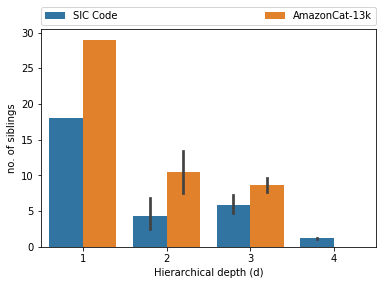

In [143]:
fig,ax = plt.subplots()
bar = sns.barplot(
    x = 'H',
    y = 'no_child',
    hue='data',
    data = df,
    ax = ax, 
#     palette=sns.color_palette("Set3"),
#     order=groups,
#     hue_order = models,
#     edgecolor = 'k',
#     linewidth=1,
#     ci=None
   )
ax.set_ylabel('no. of siblings')
ax.set_xlabel('Hierarchical depth (d)')
ax.set_xticklabels([1,2,3,4])
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
plt.show()

# PER H SCORES

In [75]:
macro_scores = pd.read_pickle('outputs/dfs/macro.pkl')
macro_scores.head()

,G,precision,F1,dir,model,loss,input,mode
lab_ind,,,,,,,,
190,G0,0.0,0.0,outputs/sic_hierarchy_c_FastText,FastText,binary,data/sic_hierarchy,top_probs
195,G0,0.0,0.0,outputs/sic_hierarchy_c_FastText,FastText,binary,data/sic_hierarchy,top_probs
196,G0,0.0,0.0,outputs/sic_hierarchy_c_FastText,FastText,binary,data/sic_hierarchy,top_probs
386,G0,0.0,0.0,outputs/sic_hierarchy_c_FastText,FastText,binary,data/sic_hierarchy,top_probs
659,G0,0.0,0.0,outputs/sic_hierarchy_c_FastText,FastText,binary,data/sic_hierarchy,top_probs


In [76]:
df = macro_scores
df = df.reset_index().set_index(['input','lab_ind'])
datas = ['sic_hierarchy','amazon_hierarchy_2']
for i,data in enumerate(datas):
    in_dir = 'data/{}'.format(data)
    _,_,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
    cnts = [y_tests[i].shape[1] for i in range(len(y_tests))]
    offsets = [0] + [cnts[i]+sum(cnts[:i]) for i in range(len(cnts))]
    for i in range(len(y_tests)):
        df.loc[(in_dir,np.arange(offsets[i],offsets[i+1])),'H']='H{}'.format(i)


In [78]:
df.head()

G  precision   F1  \
input              lab_ind                       
data/sic_hierarchy 190      G0        0.0  0.0   
                   195      G0        0.0  0.0   
                   196      G0        0.0  0.0   
                   386      G0        0.0  0.0   
                   659      G0        0.0  0.0   

                                                         dir     model  \
input              lab_ind                                               
data/sic_hierarchy 190      outputs/sic_hierarchy_c_FastText  FastText   
                   195      outputs/sic_hierarchy_c_FastText  FastText   
                   196      outputs/sic_hierarchy_c_FastText  FastText   
                   386      outputs/sic_hierarchy_c_FastText  FastText   
                   659      outputs/sic_hierarchy_c_FastText  FastText   

                              loss       mode   H  
input              lab_ind                         
data/sic_hierarchy 190      binary  top_probs  H2  
                   195      binary  top_probs  H2  
                   196      binary  top_probs  H2  
                   386      binary  top_probs  H2  
                   659      binary  top_probs  H3

In [79]:
metric_dict = {
    'precision':'Precision',
    'F1':'F1 score',
}
data_dict = {
    'data/sic_hierarchy':'SIC Code',
    'data/amazon_hierarchy_2':'AmazonCat-13k',
}

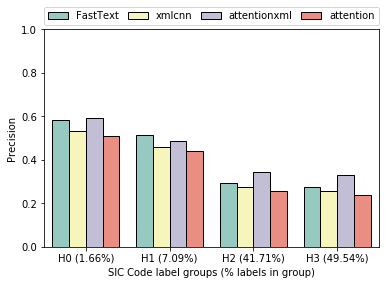

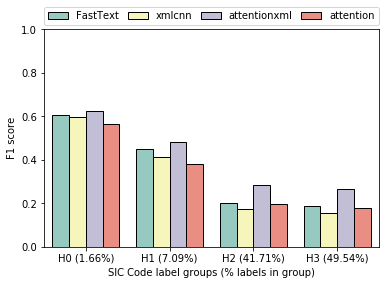

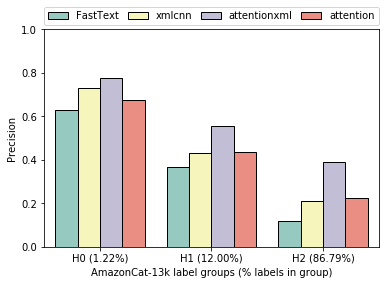

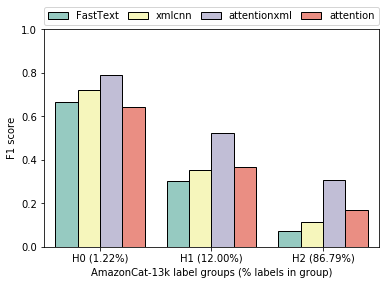

In [80]:
# model performance of binary loss
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1[df1['loss']=='binary']
for data in datas:
    df2 = df1[df1.input==data]
    for metric in metrics:
        # y tick counts
        cnts = (df2['H'].value_counts()/df2['H'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'H',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3"),
            order=groups,
            hue_order = models,
            edgecolor = 'k',
            linewidth=1,
            ci=None
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel(metric_dict[metric])
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.set_ylim(0,1)
#         ax.axhline(y=0, color='k')
        plt.show()

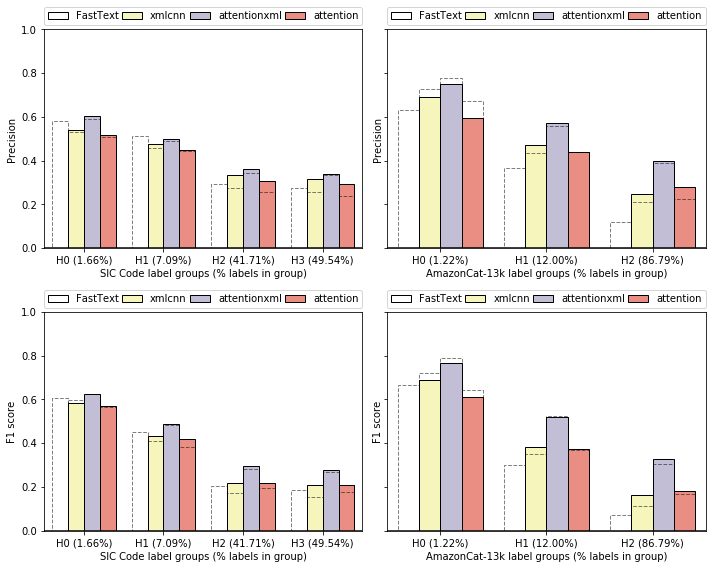

In [84]:
# model performance of _ loss (bin as ref)
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','H','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1b = (df1.loc['binary']).reset_index()
df1 = (df1.loc['masked_categorical']).reset_index()
fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
#         fig,ax = plt.subplots()
        ax = axes[i,j]
        # y tick counts
        cnts = (df2['H'].value_counts()/df2['H'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar1 = sns.barplot(
            x = 'H',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=[(1,1,1)]+sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models,
            ci=None,
            edgecolor = 'k',
            linewidth=1,
           )
        bar2 = sns.barplot(
            x = 'H',
            y=metric,
            hue='model',
            data = df1b[df1b.input==data],
            ax = ax, 
            order=groups,
            hue_order = models,
            ci=None,
            fill=False,
            alpha=0.5,
            edgecolor = 'k',
            linewidth=1,
            linestyle='--',
           )
        ax.legend(models,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('{}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
        ax.set_ylim(0,1)
#         plt.show()
plt.tight_layout()
plt.show()

# MACRO SCORES

In [220]:
args = get_args('outputs')

In [221]:
macro_scores = pd.read_pickle('outputs/dfs/macro.pkl')

In [222]:
macro_scores = macro_scores[macro_scores['model']!='bert']

In [223]:
warnings.filterwarnings('ignore')
kss = [[4],[3]]
metrics = {
    'precision':get_macro_precision,
    'F1':get_macro_F1
}
datas = ['sic_hierarchy','amazon_hierarchy_2']
loss_mode = [
    ('binary','top_probs'),
    ('categorical','top_probs'),
    ('masked_categorical','top_probs'),
]
# function
dfs = []
df = args
df = df[df['mode']=='cat']
df = df.set_index(['input','loss']).sort_index()
for i,data in enumerate(datas):
    in_dir = 'data/{}'.format(data)
    ks = kss[i]
    _,y_trains,_,y_tests = get_input(mode='cat', in_dir = in_dir, sparse = True, get_output= [0,1,0,1])
    trues = sp.hstack(y_tests).tocsr()
    groups,_ = get_groups(y_trains,num_groups = 3)
    for loss,mode in loss_mode:
        index = (in_dir,loss)
        if (in_dir,loss) not in list(df.index.values):
            continue
        else:
            print(data,loss,mode)
        dirs = sorted(df.loc[(in_dir,loss)].dir.to_list())
        if loss == 'binary':
            dirs = ['outputs/{}_c_FastText'.format(data)] + dirs
        for d in dirs:
            if d in macro_scores['dir'].unique():
                print('DATA EXISTS:{}'.format(d))
                continue
            print('.',end='')
            df1 = get_macro_scores(d,trues,y_tests,metrics,ks,mode,groups)
            df1['loss']=loss
            df1['input']=in_dir
            df1['mode']=mode
            dfs.append(df1)
        print()
df = pd.concat([macro_scores]+dfs)
# df = pd.concat(dfs)
df.to_pickle('outputs/dfs/macro.pkl')

sic_hierarchy binary top_probs
DATA EXISTS:outputs/sic_hierarchy_c_FastText
DATA EXISTS:outputs/190726_183629_xmlcnn
DATA EXISTS:outputs/190726_184436_attentionxml
DATA EXISTS:outputs/190726_202322_attention

sic_hierarchy categorical top_probs
DATA EXISTS:outputs/190726_210000_xmlcnn
DATA EXISTS:outputs/190726_210738_attentionxml
DATA EXISTS:outputs/190726_224702_attention
.
sic_hierarchy masked_categorical top_probs
DATA EXISTS:outputs/190730_141144_xmlcnn
DATA EXISTS:outputs/190730_142304_attentionxml
DATA EXISTS:outputs/190730_202748_attention

amazon_hierarchy_2 binary top_probs
DATA EXISTS:outputs/amazon_hierarchy_2_c_FastText
DATA EXISTS:outputs/190822_173202_xmlcnn
DATA EXISTS:outputs/190822_175228_attentionxml
DATA EXISTS:outputs/190823_133424_attention

amazon_hierarchy_2 categorical top_probs
DATA EXISTS:outputs/190823_172116_xmlcnn
DATA EXISTS:outputs/190823_174301_attentionxml
DATA EXISTS:outputs/190824_133144_attention
.
amazon_hierarchy_2 masked_categorical top_probs
DAT

## TABLE : macro scores

In [225]:
df = pd.read_pickle('outputs/dfs/macro.pkl')

In [44]:
models = ['FastText','xmlcnn','attentionxml','attention','bert']
indexs = ['loss','input','model']
display_metrics = ['precision','F1']
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
df2 = df
df2 = df2[df2['dir']!='outputs/190810_151748_bert'] # this bert does worst
df2 = df2.drop(columns=['dir','mode']).groupby(indexs).mean().reset_index()
df2 = df2.melt(    
    id_vars = indexs,
    value_vars = display_metrics,
    var_name = 'metric',
    value_name = 'score')
df2 = df2.set_index(indexs+['metric'])
df2 = df2.reindex(datas,level=1).reindex(models,level=2).reindex(display_metrics,level=-1)
df2 = df2.unstack(-2)
df2

score            \
model                                                 FastText    xmlcnn   
loss               input                   metric                          
binary             data/sic_hierarchy      precision  0.305074  0.283564   
                                           F1         0.218698  0.187995   
                   data/amazon_hierarchy_2 precision  0.155045  0.244085   
                                           F1         0.105603  0.149198   
categorical        data/sic_hierarchy      precision       NaN  0.329321   
                                           F1              NaN  0.233691   
                   data/amazon_hierarchy_2 precision       NaN  0.306438   
                                           F1              NaN  0.223759   
masked_categorical data/sic_hierarchy      precision       NaN  0.339919   
                                           F1              NaN  0.234694   
                   data/amazon_hierarchy_2 precision       NaN  0.279610   
                                           F1              NaN  0.194541   

                                                                             \
model                                                attentionxml attention   
loss               input                   metric                             
binary             data/sic_hierarchy      precision     0.352676  0.264263   
                                           F1            0.295537  0.205266   
                   data/amazon_hierarchy_2 precision     0.413679  0.256667   
                                           F1            0.338884  0.199054   
categorical        data/sic_hierarchy      precision     0.353030  0.291914   
                                           F1            0.305624  0.221346   
                   data/amazon_hierarchy_2 precision     0.430446  0.296073   
                                           F1            0.369860  0.241156   
masked_categorical data/sic_hierarchy      precision     0.364364  0.313610   
                                           F1            0.305033  0.232871   
                   data/amazon_hierarchy_2 precision     0.422773  0.302826   
                                           F1            0.356305  0.209530   

                                                                
model                                                     bert  
loss               input                   metric               
binary             data/sic_hierarchy      precision  0.158800  
                                           F1         0.131729  
                   data/amazon_hierarchy_2 precision       NaN  
                                           F1              NaN  
categorical        data/sic_hierarchy      precision  0.285180  
                                           F1         0.249755  
                   data/amazon_hierarchy_2 precision  0.357718  
                                           F1         0.306348  
masked_categorical data/sic_hierarchy      precision       NaN  
                                           F1              NaN  
                   data/amazon_hierarchy_2 precision       NaN  
                                           F1              NaN

In [236]:
models = ['attentionxml','bert']
indexs = ['loss','input','model']
display_metrics = ['precision','F1']
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
df2 = df
df2 = df2[df2['dir']!='outputs/190810_151748_bert'] # this bert does worst
df2 = df2.drop(columns=['dir','mode']).groupby(indexs).mean().reset_index()
df2 = df2.melt(    
    id_vars = indexs,
    value_vars = display_metrics,
    var_name = 'metric',
    value_name = 'score')
df2 = df2.set_index(indexs+['metric'])
df2 = df2.reindex(datas,level=1).reindex(models,level=2).reindex(display_metrics,level=-1)
df2 = df2.unstack(-2)
df2

score          
model                                                attentionxml      bert
loss               input                   metric                          
binary             data/sic_hierarchy      precision     0.352676  0.158800
                                           F1            0.295537  0.131729
                   data/amazon_hierarchy_2 precision     0.413679       NaN
                                           F1            0.338884       NaN
categorical        data/sic_hierarchy      precision     0.353030  0.285180
                                           F1            0.305624  0.249755
                   data/amazon_hierarchy_2 precision     0.430446  0.357718
                                           F1            0.369860  0.306348
masked_categorical data/sic_hierarchy      precision     0.364364       NaN
                                           F1            0.305033       NaN
                   data/amazon_hierarchy_2 precision     0.422773       NaN
                                           F1            0.356305       NaN

In [241]:
print((df2.loc['categorical'].stack(1).unstack(-2).droplevel(0,axis=1)*100).to_latex(float_format='%.2f'))

\begin{tabular}{llrr}
\toprule
                        & metric &  precision &    F1 \\
input & model &            &       \\
\midrule
data/sic\_hierarchy & attentionxml &      35.30 & 30.56 \\
                        & bert &      28.52 & 24.98 \\
data/amazon\_hierarchy\_2 & attentionxml &      43.04 & 36.99 \\
                        & bert &      35.77 & 30.63 \\
\bottomrule
\end{tabular}



In [ ]:
((df2.loc['categorical']-df2.loc['binary'])*100).style.applymap(_color_red_or_green).format('{:.2f}')

In [ ]:
# TABLE
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
for data in datas:
    print(data)
    df2 = df1[df1.input==data]
    srs = (df2.groupby('model')[metrics].mean()*100).to_dict()
    for metric in metrics:
        print('{:10}'.format(metric),end=':')
        print('&'.join(['{:.2f}'.format(srs[metric][key]) for key in models]))

In [ ]:
print(((df2.loc['categorical'])*100).to_latex(float_format='\tg{%.2f}',escape=False).replace(' ','').replace('&',' & '))




# PLOT : macro scores

In [205]:
df = pd.read_pickle('outputs/dfs/macro.pkl')

In [198]:
metric_dict = {
    'precision':'Precision',
    'F1':'F1 score',
}
data_dict = {
    'data/sic_hierarchy':'SIC Code',
    'data/amazon_hierarchy_2':'AmazonCat-13k',
}

In [ ]:
# model performance of binary loss
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1[df1['loss']=='binary']
for data in datas:
    df2 = df1[df1.input==data]
    for metric in metrics:
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        fig,ax = plt.subplots()
        bar = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3"),
            order=groups,
            hue_order = models,
            edgecolor = 'k',
            linewidth=1,
            ci=None
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel(metric_dict[metric])
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.set_ylim(0,1)
#         ax.axhline(y=0, color='k')
        plt.show()

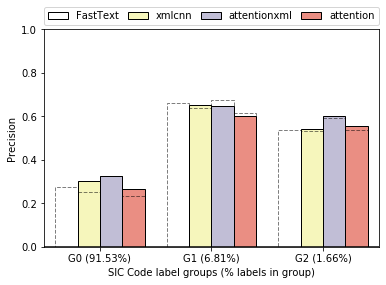

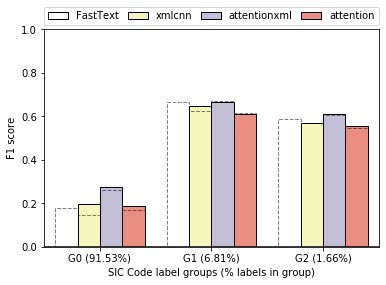

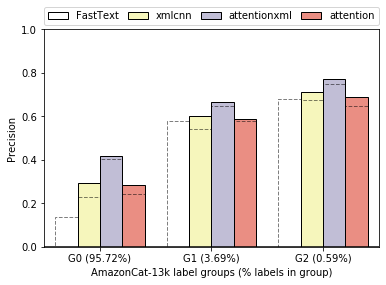

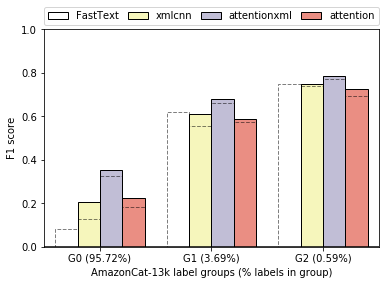

In [48]:
# model performance of categorical loss (bin as ref)
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','G','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1b = (df1.loc['binary']).reset_index()
df1 = (df1.loc['categorical']).reset_index()
# fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
        fig,ax = plt.subplots()
#         ax = axes[i,j]
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar1 = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=[(1,1,1)]+sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models,
            ci=None,
            edgecolor = 'k',
            linewidth=1,
           )
        bar2 = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df1b[df1b.input==data],
            ax = ax, 
            order=groups,
            hue_order = models,
            ci=None,
            fill=False,
            alpha=0.5,
            edgecolor = 'k',
            linewidth=1,
            linestyle='--',
           )
        ax.legend(models,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('{}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k')
        ax.set_ylim(0,1)
        plt.show()
# plt.tight_layout()
# plt.show()

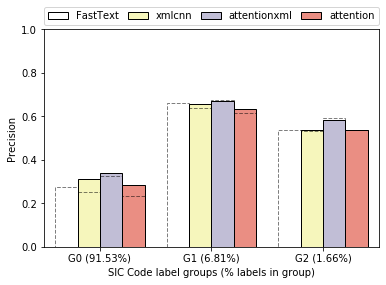

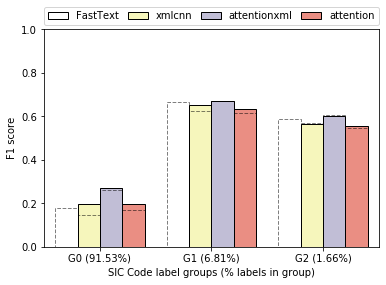

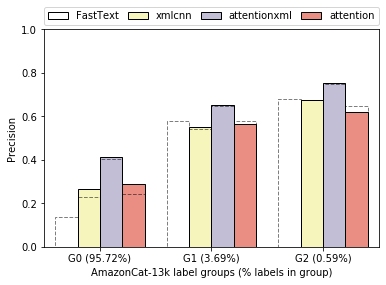

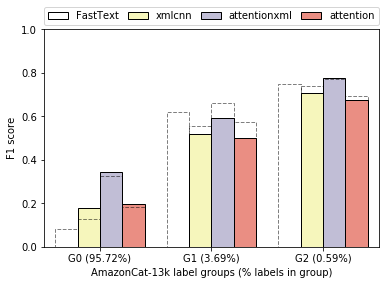

In [196]:
# model performance of HS (bin as ref)
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['FastText','xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','G','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1b = (df1.loc['binary']).reset_index()
df1 = (df1.loc['masked_categorical']).reset_index()
# fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
        fig,ax = plt.subplots()
#         ax = axes[i,j]
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar1 = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=[(1,1,1)]+sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models,
            ci=None,
            edgecolor = 'k',
            linewidth=1,
           )
        bar2 = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df1b[df1b.input==data],
            ax = ax, 
            palette=sns.color_palette("Reds")[1:],
            order=groups,
            hue_order = models,
            ci=None,
            fill=False,
            alpha=0.5,
            edgecolor = 'k',
            linewidth=1,
            linestyle='--',
           )
        ax.legend(models,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('{}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.set_ylim(0,1)
        plt.show()
# plt.tight_layout()
# plt.show()

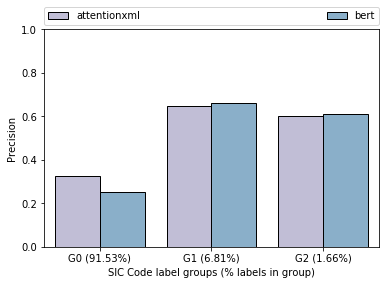

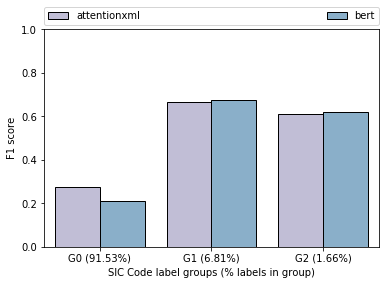

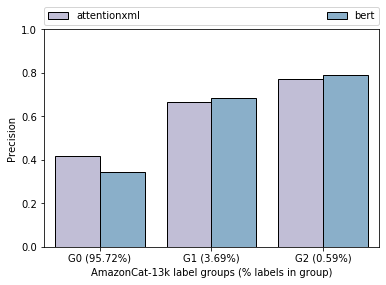

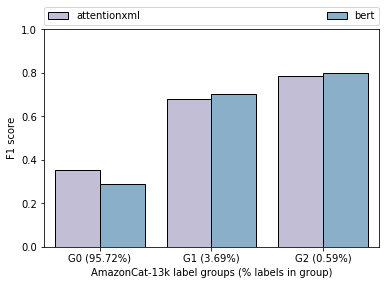

In [224]:
# model performance of cat
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['attentionxml','bert']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','G','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1 = (df1.loc['categorical']).reset_index()
# fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
        fig,ax = plt.subplots()
#         ax = axes[i,j]
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar1 = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=[sns.color_palette("Set3")[2],sns.color_palette("Set3")[4]],
            order=groups,
            hue_order = models,
            ci=None,
            edgecolor = 'k',
            linewidth=1,
           )
        ax.legend(models,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('{}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.set_ylim(0,1)
        plt.show()
# plt.tight_layout()
# plt.show()

In [ ]:
# difference, cat - bin
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','G','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1 = (df1.loc['categorical']-df1.loc['binary']).reset_index()
fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
#         fig,ax = plt.subplots()
        ax = axes[i,j]
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models,
            edgecolor = 'k',
            linewidth=1,
            ci=None
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k',linewidth=1)
        ax.set_ylim(-0.02,0.09)
#         plt.show()
plt.tight_layout()
plt.show()

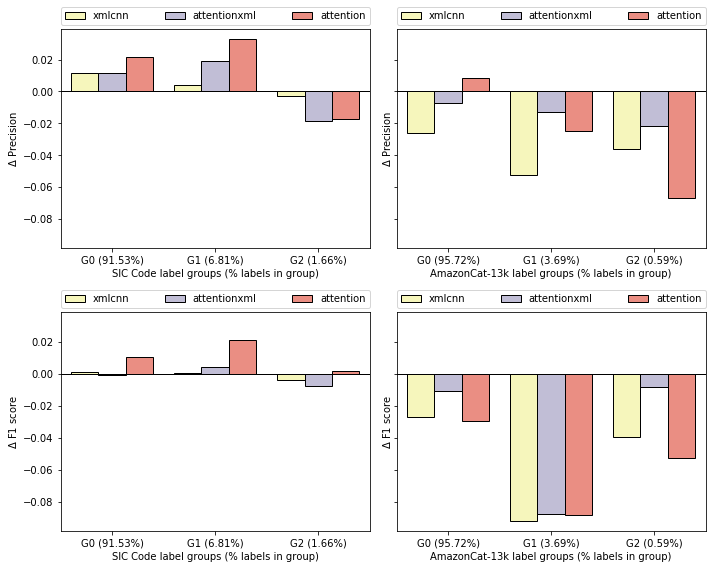

In [74]:
# difference, HS - cat
# PARAMS
datas = ['data/sic_hierarchy','data/amazon_hierarchy_2']
models = ['xmlcnn','attentionxml','attention']
metrics = ['precision','F1']
# function
df1 = df.reset_index()
df1 = df1[df1['model'].isin(models)]
df1 = df1.set_index(['loss','input','model','G','lab_ind'])
df1 = df1.drop(columns=['dir','mode'])
df1 = (df1.loc['masked_categorical']-df1.loc['categorical']).reset_index()
fig,axes = plt.subplots(2,2,sharey=True,figsize=(10,8))
for j,data in enumerate(datas):
    df2 = df1[df1.input==data]
    for i,metric in enumerate(metrics):
#         fig,ax = plt.subplots()
        ax = axes[i,j]
        # y tick counts
        cnts = (df2['G'].value_counts()/df2['G'].value_counts().sum()*100).to_dict()
        groups = sorted(cnts.keys())
        # plot
        bar = sns.barplot(
            x = 'G',
            y=metric,
            hue='model',
            data = df2,
            ax = ax, 
            palette=sns.color_palette("Set3")[1:],
            order=groups,
            hue_order = models,
            edgecolor = 'k',
            linewidth=1,
            ci=None
           )
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=len(models), mode="expand", borderaxespad=0.)
        ax.set_ylabel('$\Delta$ {}'.format(metric_dict[metric]))
        ax.set_xlabel('{} label groups (% labels in group)'.format(data_dict[data]))
        ax.set_xticklabels(['{} ({:.2f}%)'.format(key,cnts[key]) for key in groups])
        ax.axhline(y=0, color='k',linewidth=1)
#         ax.set_ylim(-0.02,0.09)
#         plt.show()
plt.tight_layout()
plt.show()